In [31]:

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os 

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


import joblib as jb
     


In [32]:
# Conectando com o db
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'data', 'data_tratados.parquet'))
# Retornando dado sem um df 
df = pd.read_parquet(data_path)
df.sample(5)

,marca,modelo,uf,vidros_eletricos,ar_condicionado,valor,VALOR_LOG,KM,KM_LOG,ano,...,gasolina,hibrido,outros,Assistida,Elétrica,Hidráulica,Mecânica,Automatica,Manual,Semiautomatica
3613,hyundai,HB20 1.0 TGDI FLEX COMFORT AUTOMÁTICO,SC,1,1,82900.0,11.325390,2726.0,7.910591,2023.0,...,0,0,0,0,1,0,0,1,0,0
2242,chevrolet,Onix Chevrolet Onix 1.0 Joy SPE/4,MT,1,1,41990.0,10.645187,8352.0,9.030256,2018.0,...,0,0,0,0,1,0,0,0,1,0
3231,hyundai,HB20 Evolution Bluelink 1.0,CE,1,1,65490.0,11.089653,5448.0,8.603004,2022.0,...,0,0,0,0,0,0,1,0,1,0
6740,audi,Q3 1.4 TFSI AMBIENTE,SP,1,1,83900.0,11.337381,8700.0,9.071078,2016.0,...,0,0,0,0,0,1,0,1,0,0
8624,land,Rover Range Rover Evoque LAND ROVER RANGER ROV...,DF,1,1,151900.0,11.930978,8370.0,9.032409,2014.0,...,1,0,0,0,0,1,0,1,0,0


## Modelagem

### Separando base de treino e teste


In [33]:
## Lista com colunas que não serão usadas
drop_colunas_x = ['KM','ANO_LOG','valor', 'marca','modelo','uf']  

dados_modelo = df.copy()
dados_modelo = dados_modelo.drop(columns=drop_colunas_x)

# Separa os dados em features (X) e target (y)
X_valores_abs = dados_modelo.drop('VALOR_LOG', axis=1)
y_valores_abs = dados_modelo['VALOR_LOG']



# Dividi os dados em treino e teste para valores orginais
X_train, X_test, y_train, y_test = train_test_split(X_valores_abs, y_valores_abs, test_size=0.2, random_state=42)


### Treinando Modelos

* LinearRegression

In [34]:
# setando o lr_model
lr_model = LinearRegression()
# Treinando o lr_model
lr_model.fit(X_train, y_train)
#previsões nos dados de teste
y_pred_abs = lr_model.predict(X_test)
# Avaliando o lr_model
mse = mean_squared_error(y_test, y_pred_abs)
r2 = r2_score(y_test, y_pred_abs)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Squared Error: 0.08650867744111401
R² Score: 0.7383715870336052


###  Validando Modelo

* Análise de Resíduos

Mean Squared Error: 0.08650867744111401
Mean Absolute Error: 0.21169061525371205
R^2 Score: 0.7383715870336052


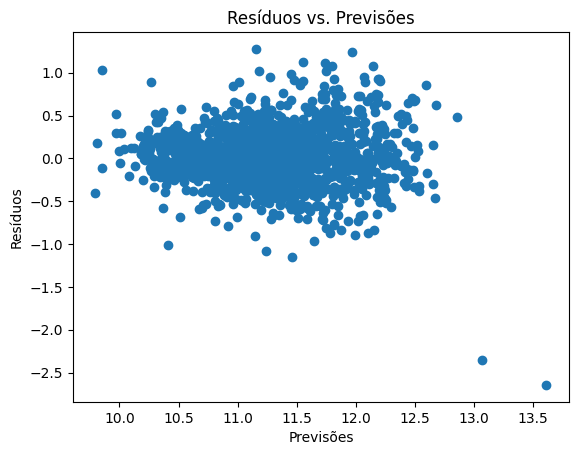

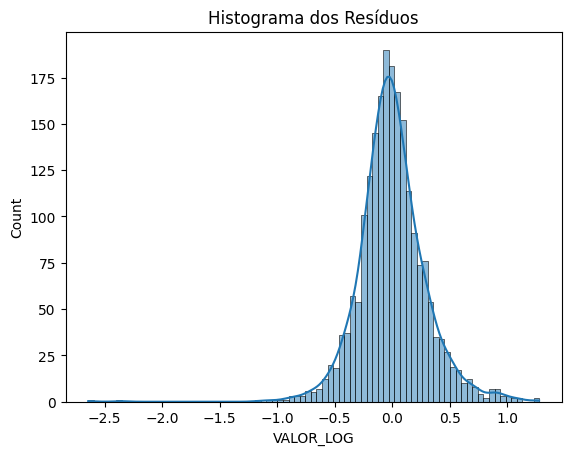

In [35]:
# Previsões do modelo
y_pred_abs = lr_model.predict(X_test)

# Calculaamdo o Mean Squared Error
mse = mean_squared_error(y_test, y_pred_abs)
mae = mean_absolute_error(y_test, y_pred_abs)
r2 = r2_score(y_test, y_pred_abs)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

# Plotar resíduos vs. previsões
residuos = y_test - y_pred_abs
plt.scatter(y_pred_abs, residuos)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Previsões')
plt.show()

# Histograma dos resíduos
sns.histplot(residuos, kde=True)
plt.title('Histograma dos Resíduos')
plt.show()


* Resíduos vs. Previsões

    * Centralização dos Resíduos:

        * Os resíduos estão centralizados em torno da linha horizontal de zero. Isso indica que o modelo não está sistematicamente subestimando ou superestimando os valores. 
        * A centralização sugere que, em média, os erros de previsão estão distribuídos igualmente  em torno de zero.

    * Dispersão Aleatória:

        * A dispersão dos resíduos parece razoavelmente aleatória, sem padrões claros visíveis.
        * Isso sugere que o modelo está capturando bem a relação entre as variáveis preditoras e a variável alvo. A falta de padrões indica que os erros são independentes e não há tendências não capturadas pelo modelo.
        
    * Homoscedasticidade:

        * A variância dos resíduos deve ser constante ao longo de todas as previsões. No gráfico, os resíduos parecem manter uma variância relativamente constante, embora haja alguns outliers.

* Histograma dos Resíduos
    * Distribuição Normal dos Resíduos:

        * O histograma dos resíduos mostra uma maioria de resíduos próximos de zero, com uma forma que se aproxima de uma distribuição normal.

    * Simetria:

        * A simetria sugere que os erros de previsão são distribuídos de forma equilibrada para cima e para baixo, indicando que o modelo não tem um viés sistemático em uma direção ou outra.

    * Outliers:

        * Há alguns resíduos mais extremos nos dois lados do gráfico. Embora alguns outliers sejam esperados, muitos outliers podem indicar que o modelo pode estar falhando em capturar todas as nuances dos dados.



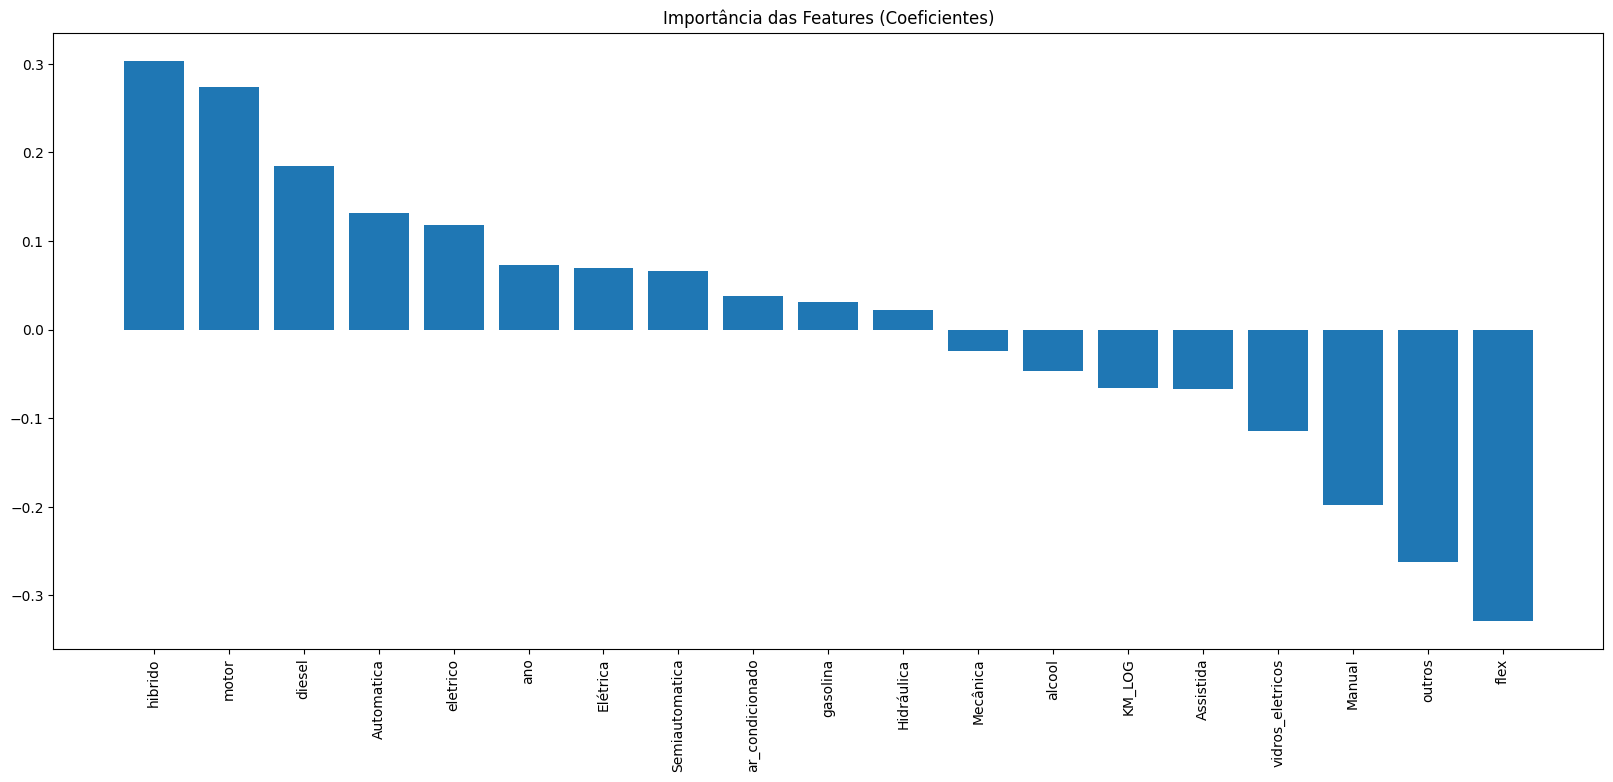

In [36]:
importances = lr_model.coef_
indices = np.argsort(importances)[::-1]
importances = lr_model.coef_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(20,8))
plt.title("Importância das Features (Coeficientes)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.show()

* Curva de Aprendizado

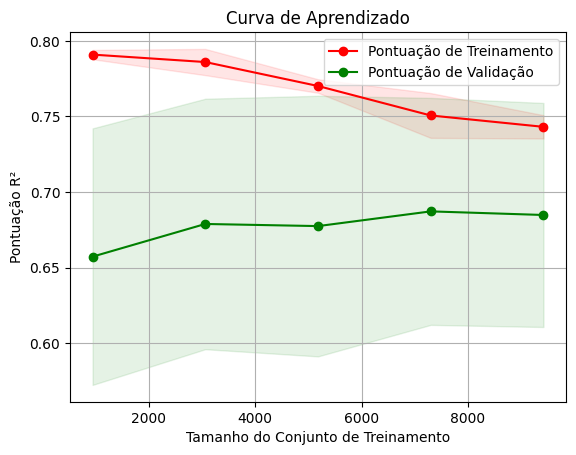

In [37]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(lr_model, X_valores_abs, y_valores_abs, cv=10, scoring='r2')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Curva de Aprendizado")
plt.xlabel("Tamanho do Conjunto de Treinamento")
plt.ylabel("Pontuação R²")
plt.grid()

# Plotar a curva de aprendizado
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Pontuação de Treinamento")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Pontuação de Validação")

plt.legend(loc="best")
plt.show()

* Pontuação de Treinamento (Curva Vermelha):

  A Pontuação de Treinamento em torno de 0.80 e diminui ligeiramente para cerca de 0.75 conforme o tamanho do conjunto de treinamento aumenta.
  Essa diminuição é esperada e indica que o modelo está se ajustando bem ao conjunto de treinamento, mas com um pouco de regularização à medida que mais dados são adicionados.


* Pontuação de Validação (Curva Verde):

  * A Pontuação de Validação começa em torno de 0.65 e sobe para cerca de 0.70.
  * Essa melhora indica que o modelo está aprendendo e generalizando melhor com o aumento do tamanho do conjunto de treinamento.
  * A variabilidade na pontuação de validação é significativa, mas não excessivamente grande, indicando uma consistência razoável.

* Conclusões
    * O novo gráfico mostra uma situação mais desejável. A pontuação R² tanto para o conjunto de treinamento quanto para o de validação está acima de 0.60, o que indica que o modelo está capturando bem os padrões nos dados.
    * Overfitting Inicial: No início, a diferença entre as pontuações de treinamento e validação é grande, sugerindo que o modelo está overfitting (ajustando-se excessivamente aos dados de treinamento).
    * Melhora na Generalização: Com o aumento do tamanho do conjunto de treinamento, a diferença entre as pontuações de treinamento e validação diminui, indicando que o modelo está generalizando melhor.
    * Limite de Desempenho: A estabilização da pontuação de validação sugere que o modelo está se aproximando do seu limite de desempenho com os dados disponíveis.
    
  Em resumo, este gráfico mostra que, inicialmente, o modelo está overfitting, mas à medida que mais dados de treinamento são adicionados, o modelo começa a generalizar melhor, reduzindo a diferença entre as pontuações de treinamento e validação.

### Salvando o Modelo

In [38]:

modelo_final = LinearRegression()
modelo_final.fit(X_train, y_train)
modelo_final.score(X_test,y_test) 

0.7383715870336052

* Criando dicionário com informações do modelo

In [39]:
modelo = modelo_final
description="""modelo Regressão Linear para prever valores de veiculos. 
Foi utilizado a normalização LOG nas variáveis KM e ANO. \
Foram utilizadas as seguintes colunas: """ + " ','".join(dados_modelo.columns)
date='02/07/2024'
version='0.1'
name_model='previsao_precos_veiculos_20240702'
metrics = {'r2': 0.7383}

dic_save_model = dict({
    'model': modelo,
    'metadata': {
        'description': description,
        'author': 'Railan Deivid',
        'date': date,
        'source_code_version': version,
        'metrics': metrics
    }
})

dic_save_model

{'model': LinearRegression(),
 'metadata': {'description': "modelo Regressão Linear para prever valores de veiculos. \nFoi utilizado a normalização LOG nas variáveis KM e ANO. Foram utilizadas as seguintes colunas: vidros_eletricos ','ar_condicionado ','VALOR_LOG ','KM_LOG ','ano ','motor ','alcool ','diesel ','eletrico ','flex ','gasolina ','hibrido ','outros ','Assistida ','Elétrica ','Hidráulica ','Mecânica ','Automatica ','Manual ','Semiautomatica",
  'author': 'Railan Deivid',
  'date': '02/07/2024',
  'source_code_version': '0.1',
  'metrics': {'r2': 0.7383}}}

In [40]:
# Salvando modelo
model_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'models', f'{name_model}.joblib'))
jb.dump(dic_save_model, model_path)

['c:\\Users\\Raila\\Documents\\Projects\\MercadoLivre_Scraper_and_CarPricePredictor\\src\\models\\previsao_precos_veiculos_20240702.joblib']